# Openai Embedding

## Api reference

### [Embedding](https://platform.openai.com/docs/api-reference/embeddings)

Get a vector representation of a given input that can be easily consumed by machine learning models and algorithms.
Related guide: [Embeddings](https://platform.openai.com/docs/guides/embeddings)
   
### Embedding object

Represents an embedding vector returned by embedding endpoint.

1. index (integer): The index of the embedding in the list of embeddings.
2. object (string): The object type, which is always "embedding".
3. embedding (array): The embedding vector, which is a list of floats. The length of vector depends on the model as listed in the [embedding guide](https://platform.openai.com/docs/guides/embeddings).

### Create embeddings

POST https://api.openai.com/v1/embeddings.
Creates an embedding vector representing the input text.

#### Request body

1. model (string) (Required): ID of the model to use. You can use the [List models](https://platform.openai.com/docs/api-reference/models/list) API to see all of your available models, or see our [Model overview](https://platform.openai.com/docs/models/overview) for descriptions of them.
2. input (string or array) (Required): Input text to embed, encoded as a string or array of tokens. To embed multiple inputs in a single request, pass an array of strings or array of token arrays. Each input must not exceed the max input tokens for the model (8191 tokens for text-embedding-ada-002) and cannot be an empty string. [Example Python code](https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb) for counting tokens.
3. user (string) (Optional): A unique identifier representing your end-user, which can help OpenAI to monitor and detect abuse. [Learn more](https://platform.openai.com/docs/guides/safety-best-practices/end-user-ids).

#### Returns

A list of embedding objects.

## 环境准备

### 安装所需依赖组件

> %pip will install the package in the virtual environment where the current notebook kernel is running. 
> While !pip will install the package in the base environment. 
> If you are using Python virtual environment (as you should!), you should use %pip.

前置通过 shell 命令，安装所依赖的 python 包。

此步骤也仅需一次执行。

In [19]:
%pip install tiktoken openai pandas matplotlib plotly scikit-learn numpy

Note: you may need to restart the kernel to use updated packages.


## 获取 Embedding 数据

此步骤为非必要步骤，可直接使用项目中已经生成过的文件信息。

### 初始化环境配置

导入此模块内，所需要的所有库

In [ ]:
import os
import json
import pandas as pd
import subprocess
import time
import openai

# 导入 tiktoken 库。Tiktoken 是 OpenAI 开发的一个库，用于从模型生成的文本中计算 token 数量。
import tiktoken

# 通过 subprocess 执行 shell 命令，获取 git 仓库的根目录
command = ['git', 'rev-parse', '--show-toplevel']
process = subprocess.Popen(command, stdout=subprocess.PIPE)
output, error = process.communicate()
git_root = output.decode().strip()

### 配置 Embedding 模型信息

该项目中，密钥配置在了根目录的 config.json 文件中，可替换为自己的密钥信息。

如使用 git 进行管理，请手动忽略该文件相关变更，避免信息泄露。

In [22]:
# 配置密钥
config_path = os.path.join(git_root, "config.json")
config = {}
with open(config_path,"r") as f:
    config = json.load(f)
openai.api_key = config["sk"]

# 模型建议使用官方推荐的第二代嵌入模型：text-embedding-ada-002
embedding_model = "text-embedding-ada-002"
# text-embedding-ada-002 模型对应的分词器（TOKENIZER）
embedding_encoding = "cl100k_base"
# text-embedding-ada-002 模型支持的输入最大 Token 数是 8191，向量维度 1536
max_tokens = 8000
# 免费账号，embeddings 限制为 150_000 tpm, 3 rpm。此处限制下每分钟请求次数为 2 次，每次为 70k token。
max_tpm = 70_000
max_rpm = 2

### 加载数据集

> Source:[美食评论数据集](https://www.kaggle.com/snap/amazon-fine-food-reviews)

数据集选择亚马逊美食评论数据集(amazon-fine-food-reviews)，该数据集包含截至 2012 年 10 月用户在亚马逊上留下的共计 568,454 条美食评论。

为了说明目的，我们将使用该数据集的一个子集（/data/fine_food_reviews_1k.csv），其中包括最近 1,000 条评论。这些评论都是用英语撰写的，并且倾向于积极或消极。每个评论都有一个产品ID、用户ID、评分、标题（摘要）和正文。

我们将把评论摘要（Summary）和正文（Text）合并成一个单一的组合文本（combined）。模型将对这个组合文本进行编码，并输出一个单一的向量嵌入。

In [31]:
input_datapath = os.path.join(git_root, "openai-api", "data", "fine_food_reviews_1k.csv")

df = pd.read_csv(input_datapath, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()

# 将 "Summary" 和 "Text" 字段组合成新的字段 "combined"
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)

### 处理数据集

Api 会有针对 rpm 和 tpm 的限制，模型会有针对单次输入的 token 的限制，此处将数组拆分为多个小列表，每次请求时，入参为单个小列表。

In [32]:
# 将 combined 列元素转为数组
combined_array = df['combined'].values.tolist()

# 从'embedding_encoding'获取编码
encoding = tiktoken.get_encoding(embedding_encoding)

# 将数组按 token 限制，进行拆分
# 拆分后小数组的集合
input_array_array = []
# 当前小数组内，input 的 token 总和
current_token_sum = 0
# 当前的小数组
current_input_array = []
# 遍历数组并拆分为小数组
for input in combined_array:
    # 如果当前小数组和超过阈值，则添加到结果列表并重新开始构建新的小数组
    input_token = len(encoding.encode(input))
    if input_token > max_tokens:
        break
    if current_token_sum + input_token > max_tpm:
        input_array_array.append(current_input_array)
        current_token_sum = 0
        current_input_array = []
    
    # 将元素添加到当前小数组中
    current_input_array.append(input)
    current_token_sum += input_token

# 添加最后一个小数组到结果列表中
input_array_array.append(current_input_array)

print("评论信息列表长度:", len(combined_array))
print("列表长度:", len(input_array_array))
for sublist in input_array_array:
    print("元素长度:", len(sublist))

评论信息列表长度: 1000
列表长度: 2
元素长度: 714
元素长度: 286


### 调用 Embedding 模型

调用 embedding 模型对应的接口。

因为前置有将输入信息做拆分，此处需要按照 rpm 的限制进行请求。

In [25]:
# 每次请求后的等待时机
sleep_time = 60 / max_rpm

# 请求结果的汇总
total_embedding = []

for input_array in input_array_array:
    res = openai.Embedding.create(
        model = "text-embedding-ada-002",
        input = input_array
    )
    data_list = res['data']
    # 按照 index 的大小对对象列表进行排序
    sorted_list = sorted(data_list, key = lambda obj: obj.index)
    # 提取排序后的 name 参数到一个新的列表
    total_embedding += [obj.embedding for obj in sorted_list]
    # 每次请求间，做一次 sleep 操作，控制 rpm
    time.sleep(sleep_time)


### 处理 Embedding 结果

将多次请求后的结果进行汇总处理，并写入进一个新的文件中。

In [33]:
df["embedding"] = total_embedding
output_datapath = os.path.join(git_root, "openai-api", "data", "fine_food_reviews_1k_with_embeddings.csv")
df.to_csv(output_datapath)

## 读取 Embedding 数据

此处我们直接读取上述计算之后的 embedding 相关的数据，后续不再重复进行请求操作。

此外，pandas 读取出的数据默认是 string 格式，需要将 embedding 数据重新转化为向量类型。

In [1]:
import os
import pandas as pd
import subprocess
import ast

# 通过 subprocess 执行 shell 命令，获取 git 仓库的根目录
command = ['git', 'rev-parse', '--show-toplevel']
process = subprocess.Popen(command, stdout=subprocess.PIPE)
output, error = process.communicate()
git_root = output.decode().strip()

embedding_datapath = os.path.join(git_root, "openai-api", "data", "fine_food_reviews_1k_with_embeddings.csv")
df_embedded = pd.read_csv(embedding_datapath, index_col=0)

print('type:', type(df_embedded["embedding"][0]))
print('dimension:', len(df_embedded["embedding"][0]))
df_embedded.head(5)

type: <class 'str'>
dimension: 34410


,Time,ProductId,UserId,Score,Summary,Text,combined,embedding
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,"[0.007060592994093895, -0.02732112631201744, 0..."
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...,"[-0.023609420284628868, -0.011784634552896023,..."
2,1351123200,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...,"Title: It isn't blanc mange, but isn't bad . ....","[0.00016697357932571322, 0.005226491950452328,..."
3,1351123200,B004AHGBX4,A2UY46X0OSNVUQ,3,These also have SALT and it's not sea salt.,I like the fact that you can see what you're g...,Title: These also have SALT and it's not sea s...,"[0.010532955639064312, -0.01354704238474369, 0..."
4,1351123200,B001BORBHO,A1AFOYZ9HSM2CZ,5,Happy with the product,My dog was suffering with itchy skin. He had ...,Title: Happy with the product; Content: My dog...,"[0.015255776233971119, -0.003898625960573554, ..."


In [2]:
# 将字符串转换为向量
df_embedded["embedding_vec"] = df_embedded["embedding"].apply(ast.literal_eval)

print('type:', type(df_embedded["embedding_vec"][0]))
print('dimension:', len(df_embedded["embedding_vec"][0]))
df_embedded.head(5)

type: <class 'list'>
dimension: 1536


,Time,ProductId,UserId,Score,Summary,Text,combined,embedding,embedding_vec
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,"[0.007060592994093895, -0.02732112631201744, 0...","[0.007060592994093895, -0.02732112631201744, 0..."
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...,"[-0.023609420284628868, -0.011784634552896023,...","[-0.023609420284628868, -0.011784634552896023,..."
2,1351123200,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...,"Title: It isn't blanc mange, but isn't bad . ....","[0.00016697357932571322, 0.005226491950452328,...","[0.00016697357932571322, 0.005226491950452328,..."
3,1351123200,B004AHGBX4,A2UY46X0OSNVUQ,3,These also have SALT and it's not sea salt.,I like the fact that you can see what you're g...,Title: These also have SALT and it's not sea s...,"[0.010532955639064312, -0.01354704238474369, 0...","[0.010532955639064312, -0.01354704238474369, 0..."
4,1351123200,B001BORBHO,A1AFOYZ9HSM2CZ,5,Happy with the product,My dog was suffering with itchy skin. He had ...,Title: Happy with the product; Content: My dog...,"[0.015255776233971119, -0.003898625960573554, ...","[0.015255776233971119, -0.003898625960573554, ..."


## T-SNE 处理数据

使用 t-SNE 模型进行降维处理，并进行绘图处理。

可以看到，t-SNE降维后，产生了大约3个大类，其中1个大类的评论大多是负面的。

In [36]:
# 导入 NumPy 包，NumPy 是 Python 的一个开源数值计算扩展。这种工具可用来存储和处理大型矩阵，
# 比 Python 自身的嵌套列表（nested list structure)结构要高效的多。
import numpy as np
# 从 matplotlib 包中导入 pyplot 子库，并将其别名设置为 plt。
# matplotlib 是一个 Python 的 2D 绘图库，pyplot 是其子库，提供了一种类似 MATLAB 的绘图框架。
import matplotlib.pyplot as plt
import matplotlib

# 从 sklearn.manifold 模块中导入 TSNE 类。
# TSNE (t-Distributed Stochastic Neighbor Embedding) 是一种用于数据可视化的降维方法，尤其擅长处理高维数据的可视化。
# 它可以将高维度的数据映射到 2D 或 3D 的空间中，以便我们可以直观地观察和理解数据的结构。
from sklearn.manifold import TSNE

# 确保你的嵌入向量都是等长的
assert df_embedded['embedding_vec'].apply(len).nunique() == 1

# 将嵌入向量列表转换为二维 numpy 数组
matrix = np.vstack(df_embedded.embedding_vec.values)

# 创建一个 t-SNE 模型，t-SNE 是一种非线性降维方法，常用于高维数据的可视化。
# n_components 表示降维后的维度（在这里是2D）
# perplexity 可以被理解为近邻的数量
# random_state 是随机数生成器的种子
# init 设置初始化方式
# learning_rate 是学习率。
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)

# 使用 t-SNE 对数据进行降维，得到每个数据点在新的2D空间中的坐标
vis_dims = tsne.fit_transform(matrix)

In [39]:
# 定义了五种不同的颜色，用于在可视化中表示不同的等级
colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]

# 从降维后的坐标中分别获取所有数据点的横坐标和纵坐标
x = [x for x,_ in vis_dims]
y = [y for _,y in vis_dims]

# 根据数据点的评分（减1是因为评分是从1开始的，而颜色索引是从0开始的）获取对应的颜色索引
color_indices = df_embedded.Score.values - 1

# 确保你的数据点和颜色索引的数量匹配
assert len(vis_dims) == len(df_embedded.Score.values)

# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)
# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定，alpha 是点的透明度
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)

# 为图形添加标题
plt.title("Amazon ratings visualized in language using t-SNE")

## 使用 K-Means 聚类，然后使用 t-SNE 可视化

Openai 文档中有提及，这 1000 条评论，通过 K-Means 聚类可视化效果可分为 4 类：一个专注于狗粮，一个专注于负面评论，两个专注于正面评论

In [43]:
import numpy as np
# 从 scikit-learn中导入 KMeans 类。KMeans 是一个实现 K-Means 聚类算法的类。
from sklearn.cluster import KMeans

# np.vstack 是一个将输入数据堆叠到一个数组的函数（在垂直方向）。
# 这里它用于将所有的 ada_embedding 值堆叠成一个矩阵。
matrix = np.vstack(df_embedded.embedding_vec.values)

# 定义要生成的聚类数。
n_clusters = 4

# 创建一个 KMeans 对象，用于进行 K-Means 聚类。
# n_clusters 参数指定了要创建的聚类的数量；
# init 参数指定了初始化方法（在这种情况下是 'k-means++'）；
# random_state 参数为随机数生成器设定了种子值，用于生成初始聚类中心。
# n_init=10 消除警告 'FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4'
kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42, n_init=10)

# 使用 matrix（我们之前创建的矩阵）来训练 KMeans 模型。这将执行 K-Means 聚类算法。
kmeans.fit(matrix)

# kmeans.labels_ 属性包含每个输入数据点所属的聚类的索引。
# 这里，我们创建一个新的 'Cluster' 列，在这个列中，每个数据点都被赋予其所属的聚类的标签。
df_embedded['Cluster'] = kmeans.labels_

print(df_embedded.Cluster)

0      2
1      2
2      3
3      3
4      0
      ..
995    2
996    0
997    1
998    2
999    1
Name: Cluster, Length: 1000, dtype: int32


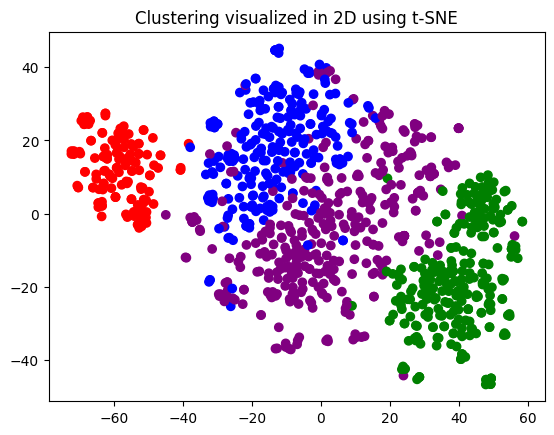

In [44]:
# 首先为每个聚类定义一个颜色。
colors = ["red", "green", "blue", "purple"]

# 然后，你可以使用 t-SNE 来降维数据。这里，我们只考虑 'embedding_vec' 列。
tsne_model = TSNE(n_components=2, random_state=42)
vis_data = tsne_model.fit_transform(matrix)

# 现在，你可以从降维后的数据中获取 x 和 y 坐标。
x = vis_data[:, 0]
y = vis_data[:, 1]

# 'Cluster' 列中的值将被用作颜色索引。
color_indices = df_embedded['Cluster'].values

# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)

# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定
plt.scatter(x, y, c=color_indices, cmap=colormap)

# 为图形添加标题
plt.title("Clustering visualized in 2D using t-SNE")

# 显示图形
plt.show()

## 使用 Embedding 进行文本搜索

通过 cosine_similarity 函数计算两个嵌入向量之间的余弦相似度，并作为搜索匹配结果。

In [8]:
from openai.embeddings_utils import get_embedding, cosine_similarity
import openai
import json

config_path = os.path.join(git_root, "config.json")
config = {}
with open(config_path,"r") as f:
    config = json.load(f)
openai.api_key = config["sk"]

In [5]:
''' 
查找与描述最相符的文本信息 

Args:
    df: 向量数据库
    description: 信息描述
    n: 查找数量
    pprint: 是否打印查找结果

Returns:
    与信息描述最相符的 n 个结果
'''
def search_comment(df, description, n=3, pprint=True):
    product_embedding = get_embedding(
        description,
        engine="text-embedding-ada-002"
    )

    # 计算 df 中的信息，与信息描述的关联性
    df["similarity"] = df.embedding_vec.apply(lambda x: cosine_similarity(x, product_embedding))

    # 获取关联性最高的 n 个结果
    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results

In [9]:
# 使用 'delicious beans' 作为信息描述和 3 作为数量，
# 调用 search_comment 函数来查找与给定产品描述最相似的前3条评论。
# 其结果被存储在 res 变量中。
res = search_comment(df_embedded, 'delicious beans', n=3)

Good Buy:  I liked the beans. They were vacuum sealed, plump and moist. Would recommend them for any use. I personally split and stuck them in some vodka to make vanilla extract. Yum!

Jamaican Blue beans:  Excellent coffee bean for roasting. Our family just purchased another 5 pounds for more roasting. Plenty of flavor and mild on acidity when roasted to a dark brown bean and befor

Delicious!:  I enjoy this white beans seasoning, it gives a rich flavor to the beans I just love it, my mother in law didn't know about this Zatarain's brand and now she is traying different seasoning

